In [1]:
#building BGRS version 0

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import chain, combinations

# BGRS

In [3]:
def GRS_score(Y: np.ndarray, X: np.ndarray) -> float:
    """
    Calculate the GRS score described in BarillasShanken2018 eq. 3 or, the original paper, Gibbons et al. (1989) or Cochrane2005
    Note that Gibbons et al. (1989) have an additional multiplicative constant that vanish asymptotically and thus is not appearing here.

    Parameters:
        Y (np.ndarray): Dependent variable matrix of dimensions T x N.
        X (np.ndarray): Independent variable matrix of dimensions T x K.

    
    Returns:
        float: GRS score of linear regression Y on X. It is NOT the p-value, it requires additional processing
    """
    
    T, N = Y.shape
    K = X.shape[1]

    # Add a constant term to the independent variable matrix X
    X_with_intercept = sm.add_constant(X)

    # Initialize arrays to store parameters
    alpha = np.zeros((1, N))
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X_with_intercept)
        results = model.fit()

        # Extract parameters
        alpha[0, n] = results.params[0]
        beta[:, n] = results.params[1:]
        residuals[:, n] = results.resid


    #create Epsilon ~ (N,N) and its inverse
    Epsilon=np.cov(residuals,rowvar=False,bias=True) 
    if N==1:
        inverse_Epsilon=1/Epsilon

    else:
        inverse_Epsilon=np.linalg.inv(Epsilon)

    #average of factors X
    mu=np.mean(X,axis=0)


    #covariance of factors X and its inverse
    Omega=np.cov(X,rowvar=False,bias=True) 

    if K==1:
        inverse_Omega=1/Omega

    else:
        inverse_Omega=np.linalg.inv(Omega)

  
    
    GRS=((T-N-K)/N)*np.dot(np.dot(alpha, inverse_Epsilon), alpha.T)/(1+np.dot(np.dot(mu.T, inverse_Omega), mu))
    GRS=float(GRS[0,0]) #convert to float

    #alternative score (NOT USED)
    Wald=T * np.dot(np.dot(alpha, inverse_Epsilon), alpha.T)/(1+np.dot(np.dot(mu.T, inverse_Omega), mu))
    Wald=float(Wald[0,0])
    
    
    return GRS

In [4]:
def ML_unrestricted(X: np.ndarray, Y: np.ndarray, prior_multiple: float ) -> float:
    """
    Calculate the marginal likelihoods of the unrestricted linear regression model in BarillasShanken2018 eq. 9:
    Yt = α + Xt β + εt (non restricted)

    Yt : shape = (T x N)

    Xt : shape = (T x K)


    
    α ~ 1 x N
    β ~ K x N
    ε ~ T x N

    Note that the function ML_u(Y|X) is used with different combination of factors and returns to input as Y and X.
    Therefore, we make a quick summary of what happens for 3 alternatives in the paper:

    I. Testing a pricing model against a general alternative ~ common α=0 test (close to GRS)

        BF=ML(H0)/ML(H1)=ML_r( Y = portfolio returns| X = [factors, Mkt] )/ML_u( Y = portfolio returns| X = [factors, Mkt] )

            note that we always make the distinction between factors and the market factor because the market is
            always included as exogenous variables. The associated linear regression here is :  rt = α + Ft β + εt    as defined in
            BarillasShanken2018 eq. 1 where F contains both non-market and market factors. 

        p = BF / (1 + BF) = "probability of observing our data under the null hypothesis (here: all alpha are zeros)"

    II. Relative model tests 

        BF abs/Mα = ML_r( Y = portfolio returns| X = [factors, Mkt] )/ML_u( Y = portfolio returns| X = [factors, Mkt] )
        
            This equation is the same as in I. Note that the difference with the equation below eq. 16 in BarillasShanken2018
            comes from a simplification as numerator and demoninator cancels each other. Also note that factors = [f, f*] 
            where f = included factors and f* = excluded factors.

            H0 : "all alpha are zeros"

        BF abs/M = ML_r( Y = f*| X = [f, Mkt] ) / ML_u( Y = f*| X = [f, Mkt] )
                    * ML_r( Y = portfolio returns| X = [f, Mkt] ) / ML_u( Y = portfolio returns| X = [f, Mkt] )

            Observe that this equation cover the following linear regression: [r, f*]t = α + [f,Mkt]t β + εt
            which is essentially two uncoupled linear regression: rt = α + [f,Mkt]t β + εt  and  [f*]t = α + [f,Mkt]t β + εt
            This is reflected in the fact that r and f* are not mixed when appearing in the marginal likelihoods.

            H0 : f is sufficient to price the returns (against the more general alternative [f,f*])

        BF rel = ( BF abs/M  ) /  ( BF abs/Mα ) = ML_r( Y = f*| X = [f, Mkt] )/ML_u( Y = f*| X, Mkt = f, Mkt )

            Naturally, the relative bayesian factor does not involve r. 

            H0 : f is sufficient as pricing factors (against the more general alternative [f,f*])

            Note that BarillasShanken2018 explain that the conclusion regarding the two last propositions are related and the
            same which is illustrated by the fact that BF rel = ( BF abs/M  ) /  ( BF abs/Mα ).

    III. Simultaneous Comparison of All Models Based on a Set of Factors

        P(Mi|D)=MLi/sum{j}(MLj) 

        MLi = ML_u( Y = f| X = [None, Mkt] ) *  ML_r( Y = f*| X = [f, Mkt] ) * ML_r( Y = r| X = [f, f*, Mkt] )

            where f and f* are two complementary subsets of all the factors proper to model i. Note that the last term is common 
            to all models, therefore it can be dropped if we only intend to use MLi to compute P(Mi|D) as the common factors cancel
            each other. The fact that the returns no longer appear in the final score is not a problem since we observed an  
            analogous situation with BF rel and BF abs/Mα being closely related despite the absence of returns in the relative version.

        now you can compare the probability associated to each models (to each combination of included/excluded subsets of factors) and
        decide which one is better to use as pricing factors.




    comparison with notation (in the code) and BarillasShanken2018 eq. 9:
    
    |F'F| = |X'X|
    with X'X : shape = (K x K)
    note that X MUST contains the market factor.
    
    |S| = |ε'ε|
    with ε'ε ~ (N x N)

    Q is constructed with the GRS score based on the regression Yt = α + Xt β + εt


    Parameters:
        Y (np.ndarray)                 : factors on the LHS
        X (np.ndarray)                 : factors on the RHS 
        Mkt (np.ndarray)               : Market excess return Mkt-Rf, T x 1
        prior_multiple (float)         : scalar use to define k from Sh_mkt (BarillasShanken2018 eq. 7)

    Returns:
        float: Marginal log-likelihood of the unrestricted linear regression model.
    """


    
    T, N = Y.shape
    K = X.shape[1] 

    if N==0: return 0 

    # Add a constant term to the independent variable matrix X
    X_with_intercept = sm.add_constant(X)

    # Initialize arrays to store parameters
    alpha = np.zeros((1, N))
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X_with_intercept)
        results = model.fit()

        # Extract parameters
        alpha[0, n] = results.params[0]
        beta[:, n] = results.params[1:]
        residuals[:, n] = results.resid

    #compute the relevant term for Marginal likelihood
    #note that the involved number can become very large
    #thus the use of logairthm is required.
    #BarillasShanken2018 showed a simplification of the problematic
    #terms but it only hold for specific case.
    
    lnXX=np.log(np.linalg.det(X.T @ X))

    lnS=np.log(np.linalg.det(residuals.T @ residuals))

    #construction of W
    W=GRS_score(Y,X)*(N*T)/(T-N-K)

    #construction of sharp ratio of X
    
    #average of factors X
    mu=np.mean(X,axis=0)

    #covariance of factors X and its inverse
    Omega=np.cov(X,rowvar=False,bias=True) 
    if K==1:
        inverse_Omega=1/Omega

    else:
        inverse_Omega=np.linalg.inv(Omega)

    #it is im portant to understand that mu * Omega**-1 * mu = Sh(X)**2 which appears clear by comparing 
    #the GRS score in BarillasShanken2018 eq.3 with the original paper, Gibbons et al. (1989)
    Sharp_ratio_X_2=np.dot(np.dot(mu.T, inverse_Omega), mu)

    #construction of k and a:
    k=(prior_multiple**2-1)*Sharp_ratio_X_2/N
    
    a=(1+Sharp_ratio_X_2)/T

    #construction of Q
    lnQ=np.log(1+(a/(a+k))*(W/T))*(-(T-K)/2) + np.log(1+k/a)*(-N/2)

    
    lnML_u=lnXX*(-N/2)+lnS*(-(T-K)/2)+lnQ
    return lnML_u

In [5]:
def ML_restricted(X: np.ndarray, Y: np.ndarray) -> float:
    """
    Calculate the marginal likelihoods of the restricted linear regression model in BarillasShanken2018 eq. 9:
    Yt = Xt β + εt (restricted)

    Yt : shape = (T x N)

    Xt : shape = (T x K)


    
    β ~ K x N
    ε ~ T x N

    Note that the function ML_r(Y|X) is used with different combination of factors and returns to input as Y and X.
    Therefore, we made a quick summary in the function ML_unrestricted to help.


    comparison with notation (in the code) and BarillasShanken2018 eq. 9:
    
    |F'F| = |X'X|
    with X'X : shape = (K x K)
    note that X MUST contains the market factor.

    |SR| = |ε'ε|
    with ε'ε ~ (N x N)

    Parameters:
        Y (np.ndarray)                 : factors on the LHS
        X (np.ndarray)                 : factors on the RHS 
        prior_multiple (float)         : scalar use to define k from Sh_mkt (BarillasShanken2018 eq. 7)

    Returns:
        float: Marginal log-likelihood of the restricted linear regression model.
    """


    
    T, N = Y.shape
    K = X.shape[1] 

    
    if N==0: return 0 

    # Initialize arrays to store parameters
    beta = np.zeros((K, N))
    residuals = np.zeros((T, N))

    # Loop over each target variable
    for n in range(N):
        # Fit OLS regression model for each target variable
        model = sm.OLS(Y[:, n], X)
        results = model.fit()

        # Extract parameters
        beta[:, n] = results.params
        residuals[:, n] = results.resid

    #compute the relevant term for Marginal likelihood
    lnXX=np.log(np.linalg.det(X.T @ X))

    lnSR=np.log(np.linalg.det(residuals.T @ residuals))


    lnML_r=lnXX*(-N/2)+lnSR*(-(T-K)/2)
    return lnML_r

In [6]:
def ML(F: np.ndarray, F_excluded: np.ndarray, Mkt: np.ndarray, prior_multiple: float ) -> float:
    """
    Calculate the marginal likelihoods as defined in eq.19 in BarillasShanken2018 using the restricted and unrestricted marginal 
    likelihoods previously defined. The last term is omitted since it will cancel out in the following (eq.17).
    Note that the canceling is mentionned in BarillasShanken2018 and we follow their path. 

    
    Parameters:
        F (np.ndarray)         : Included factors in the model to be tested, T x (K-K_excluded)
        F_excluded (np.ndarray): Excluded factors in the model to be tested, T x K_excluded
        Mkt (np.ndarray)       : Market excess return Mkt-Rf, T x 1
        prior_multiple (float) : square of the maximum expected sharp ratio

    Returns:
        float: Marginal log-likelihood
    """

    lnML=ML_unrestricted(Mkt, F, prior_multiple)+ML_restricted(np.concatenate((F,Mkt),axis=1), F_excluded)

    return lnML

In [7]:
def all_possibilities_BGRS(l: list) -> list:
    """
    Compute all combinations of factors possible using the inputed list of name of factors.

    Parameters:
        l(List[str]): list of name of factors

    Returns:
        List[List[str]]: list of all sublist of name of factors
    """

    def all_subsets(values):
        subsets = []
        for r in range(len(values)+1):
            #if r>0:
                subsets.extend(list(combinations(values, r)))
        return subsets

    complete_set=set(l)

    list_subset=all_subsets(complete_set)

    return list_subset

In [8]:
def from_marginal_likelihood_to_probability(df_results: pd.DataFrame) -> pd.DataFrame:
    """
    last step of the BGRS, the function transforms the marginal log-likelihoods to posterior probabilities. Since the involved numbers
    are large, the function is careful when taking the exponential of such combination of numbers. 

    Following the steps of BarillasShanken2018 (eq.17), we compute the posterior probabilities assuming uniform prior model probabilities.

    P(Mi|D)=MLi/sum{j}(MLj)=1/sum{j}(MLj/MLi)

    and focusing on the sum in the denominator:

    sum{j}(MLj/MLi)=sum{j}(exp(lnMLj-lnMLi))

    Parameters:
        df_results (pd.DataFrame) : DataFrame containing marginal log-likelihoods for given combinations of factors

    Returns:
        dataframe containing the posterior probabilities, the format is the same as the one inputed
    """

    
    # Define a function to compute P_i for each value
    def compute_P_i(value, row):
        exp_sum = np.sum(np.exp(row.values - value))
        return 1 / exp_sum
    
    # Apply the function to each value in the DataFrame
    df_proba = df_results.apply(lambda row: row.apply(lambda x: compute_P_i(x, row)), axis=1)

    

    return df_proba
    
    

In [9]:
def BGRS_III(factors: pd.DataFrame, prior_multiple: float, list_of_models: list = None) -> pd.DataFrame:
    """
    Perform the BGRS analysis (the third version, comparing subsets of factors) using the provided factors and a
    prior parameter

    Parameters:
        factors (pd.DataFrame)          : DataFrame containing factors. Note that one column should absolutely be named "Mkt-RF", T x K
        prior_multiple (float)          : Prior parameters used later in the computation of the maximum expected sharp ratio. 
        list_of_model (list)            : list of model to be analyzed, if None is provided compute all possible models

    !!! Note that a "model" is a list of factors name (strings) which must correspond to columns in factors (inputed dataframe)
    !!! Note that the index of factors should be time ordered.
    !!! Note that one column should absolutely be named "Mkt-RF", T x K

    
    Returns:
        dataframe containing the marginal log-likelihood of all models of interest
    """

    #to avoid future problem we must satisfy (see GRS) T>N+K, therefore we use the max of N and K as threshold
    N=factors.shape[1]
    K=factors.shape[1]
    
    #If None is provided compute all possible models

    all_factors_name=list(factors.drop(columns=["Mkt-RF"]).columns)
   
    if list_of_models==None:
        list_of_models=all_possibilities_BGRS(all_factors_name)

    #initialize dictionnary to store marginal likelihoods
    dict_results={"index":list(factors.index)}
    
    for model in list_of_models:
        
        name_model=" ".join(list(model))

        names_F_included=list(model)
        names_F_excluded= [string for string in all_factors_name if string not in list(model)]

        #extract the relevant data from the dataframes
        F_included=factors[names_F_included].copy(deep=True)
        F_excluded=factors[names_F_excluded].copy(deep=True)

        Market=factors["Mkt-RF"]

        
        log_marginal_likelihoods=[]
        for index_date,date in enumerate(dict_results["index"]):
            if index_date<=N+K:
                log_marginal_likelihoods.append(np.nan)
            else:   
                #to be removed
                #print("------------------------------------------------")
                #print(F_included[:index_date].values.shape)
                #print(F_excluded[:index_date].values.shape)
                #print(Market[:index_date].values.reshape(-1,1).shape)
                #print(return_portfolio[:index_date].values.shape)
                
                
                log_marginal_likelihoods.append(ML(F_included[:index_date].values,
                                              F_excluded[:index_date].values,
                                              Market[:index_date].values.reshape(-1,1),
                                              prior_multiple))

        
                


        dict_results[name_model]=log_marginal_likelihoods
        
    return from_marginal_likelihood_to_probability(pd.DataFrame(dict_results).set_index('index'))
    
    
    
    
    

# TEST

In [10]:
all_possibilities_BGRS(["a","b","c","d","e","f"])

[(),
 ('d',),
 ('b',),
 ('e',),
 ('c',),
 ('a',),
 ('f',),
 ('d', 'b'),
 ('d', 'e'),
 ('d', 'c'),
 ('d', 'a'),
 ('d', 'f'),
 ('b', 'e'),
 ('b', 'c'),
 ('b', 'a'),
 ('b', 'f'),
 ('e', 'c'),
 ('e', 'a'),
 ('e', 'f'),
 ('c', 'a'),
 ('c', 'f'),
 ('a', 'f'),
 ('d', 'b', 'e'),
 ('d', 'b', 'c'),
 ('d', 'b', 'a'),
 ('d', 'b', 'f'),
 ('d', 'e', 'c'),
 ('d', 'e', 'a'),
 ('d', 'e', 'f'),
 ('d', 'c', 'a'),
 ('d', 'c', 'f'),
 ('d', 'a', 'f'),
 ('b', 'e', 'c'),
 ('b', 'e', 'a'),
 ('b', 'e', 'f'),
 ('b', 'c', 'a'),
 ('b', 'c', 'f'),
 ('b', 'a', 'f'),
 ('e', 'c', 'a'),
 ('e', 'c', 'f'),
 ('e', 'a', 'f'),
 ('c', 'a', 'f'),
 ('d', 'b', 'e', 'c'),
 ('d', 'b', 'e', 'a'),
 ('d', 'b', 'e', 'f'),
 ('d', 'b', 'c', 'a'),
 ('d', 'b', 'c', 'f'),
 ('d', 'b', 'a', 'f'),
 ('d', 'e', 'c', 'a'),
 ('d', 'e', 'c', 'f'),
 ('d', 'e', 'a', 'f'),
 ('d', 'c', 'a', 'f'),
 ('b', 'e', 'c', 'a'),
 ('b', 'e', 'c', 'f'),
 ('b', 'e', 'a', 'f'),
 ('b', 'c', 'a', 'f'),
 ('e', 'c', 'a', 'f'),
 ('d', 'b', 'e', 'c', 'a'),
 ('d', 'b', '

In [27]:
df=pd.read_csv('../../../test_BGRS.csv')
df=pd.read_csv('../../../FF5_test_BGRS.csv')
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df.set_index('date', inplace=True)

In [28]:
df

,Mkt-RF,SMB,HML,RMW,CMA,RF,UMD,CyberFactor
date,,,,,,,,
2009-01-01,-0.0812,-0.0213,-0.1129,0.0018,-0.0116,0.0000,-0.0218,0.078395
2009-02-01,-0.1010,-0.0133,-0.0695,0.0119,-0.0102,0.0001,0.0441,0.124764
2009-03-01,0.0895,0.0068,0.0348,-0.0252,-0.0224,0.0002,-0.1187,0.001850
2009-04-01,0.1018,0.0713,0.0536,0.0131,0.0013,0.0001,-0.3430,0.018830
2009-05-01,0.0521,-0.0232,0.0027,-0.0078,-0.0216,0.0000,-0.1249,-0.058237
...,...,...,...,...,...,...,...,...
2022-07-01,0.0957,0.0186,-0.0410,0.0068,-0.0692,0.0008,-0.0394,0.060134
2022-08-01,-0.0377,0.0149,0.0030,-0.0478,0.0130,0.0019,0.0199,-0.030872
2022-09-01,-0.0935,-0.0097,0.0006,-0.0151,-0.0084,0.0019,0.0347,-0.022497


In [31]:
#return_portfolio=df[portfolio_list].copy(deep=True)
factors=df.drop(columns=["RF"]).copy(deep=True)

df_results=BGRS_III(factors,1.5)


RMW
HML
CyberFactor
UMD
SMB
CMA
RMW HML
RMW CyberFactor
RMW UMD
RMW SMB
RMW CMA
HML CyberFactor
HML UMD
HML SMB
HML CMA
CyberFactor UMD
CyberFactor SMB
CyberFactor CMA
UMD SMB
UMD CMA
SMB CMA
RMW HML CyberFactor
RMW HML UMD
RMW HML SMB
RMW HML CMA
RMW CyberFactor UMD
RMW CyberFactor SMB
RMW CyberFactor CMA
RMW UMD SMB
RMW UMD CMA
RMW SMB CMA
HML CyberFactor UMD
HML CyberFactor SMB
HML CyberFactor CMA
HML UMD SMB
HML UMD CMA
HML SMB CMA
CyberFactor UMD SMB
CyberFactor UMD CMA
CyberFactor SMB CMA
UMD SMB CMA
RMW HML CyberFactor UMD
RMW HML CyberFactor SMB
RMW HML CyberFactor CMA
RMW HML UMD SMB
RMW HML UMD CMA
RMW HML SMB CMA
RMW CyberFactor UMD SMB
RMW CyberFactor UMD CMA
RMW CyberFactor SMB CMA
RMW UMD SMB CMA
HML CyberFactor UMD SMB
HML CyberFactor UMD CMA
HML CyberFactor SMB CMA
HML UMD SMB CMA
CyberFactor UMD SMB CMA
RMW HML CyberFactor UMD SMB
RMW HML CyberFactor UMD CMA
RMW HML CyberFactor SMB CMA
RMW HML UMD SMB CMA
RMW CyberFactor UMD SMB CMA
HML CyberFactor UMD SMB CMA
RMW HML

<Axes: xlabel='index'>

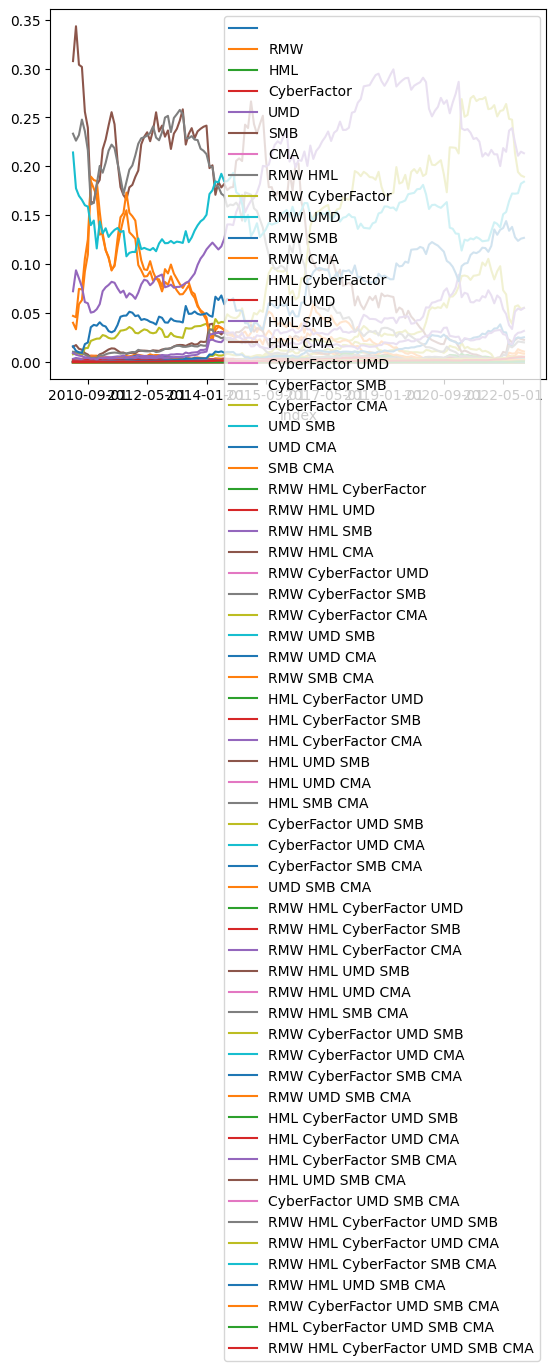

In [32]:

df_results.plot()
        

<Axes: xlabel='index'>

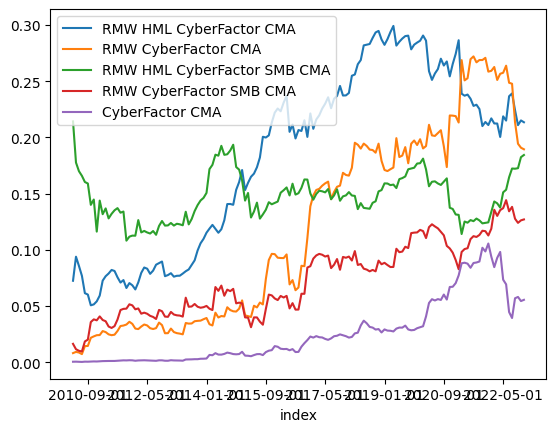

In [33]:
# Step 2: Check the last values of each column
last_values = df_results.iloc[-1]  # Assuming the last row contains the last values

# Step 3: Find the top 5 values
top_values = last_values.nlargest(5)

# Step 4: Plot the columns with last value in the top 5
list_to_plot=[]
for column in top_values.index:
    list_to_plot.append(column)

df_results[list_to_plot].plot()


In [26]:
df

,portfolio_0,portfolio_1,portfolio_2,portfolio_3,portfolio_4,portfolio_5,portfolio_6,portfolio_7,portfolio_8,portfolio_9,...,portfolio_15,portfolio_16,portfolio_17,portfolio_18,portfolio_19,Mkt-RF,HML,SMB,UMD,CyberFactor
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,-0.056200,-0.164319,-0.059854,-0.108204,-0.048161,-0.085459,-0.024610,-0.097914,-0.111751,-0.077828,...,-0.018928,-0.051353,-0.014987,-0.043912,-0.033305,-0.0812,-0.1129,-0.0213,-0.0218,0.072965
2009-02-01,-0.125285,-0.201739,-0.140227,-0.110914,-0.149718,-0.093972,-0.099319,-0.089248,-0.175799,-0.121045,...,-0.111401,-0.044172,-0.048620,0.022120,-0.024743,-0.1010,-0.0695,-0.0133,0.0441,0.121804
2009-03-01,0.074661,0.200013,0.097622,0.120091,0.116993,0.099606,0.102173,0.104052,0.133305,0.095396,...,0.067364,0.074809,0.108356,0.127252,0.162150,0.0895,0.0348,0.0068,-0.1187,0.003146
2009-04-01,0.134446,0.083502,0.057643,0.197626,0.054872,0.073000,0.099730,0.076573,0.212761,0.180376,...,0.062367,0.120588,0.138674,0.074091,0.118439,0.1018,0.0536,0.0713,-0.3430,0.018943
2009-05-01,0.073442,0.097378,0.073564,0.057462,0.057013,0.081026,0.097700,0.053974,0.105960,0.038000,...,0.109949,0.014359,0.035635,0.016891,0.016080,0.0521,0.0027,-0.0232,-0.1249,-0.058402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,-0.011060,0.008676,-0.034988,-0.013394,-0.023582,-0.040173,-0.029718,-0.042820,-0.020943,-0.027800,...,-0.037759,-0.043981,-0.037967,-0.047416,-0.054733,-0.0377,0.0030,0.0149,0.0199,-0.032963
2022-09-01,-0.107215,-0.092879,-0.065723,-0.089417,-0.094778,-0.074409,-0.095665,-0.079029,-0.113778,-0.095303,...,-0.102678,-0.067866,-0.112119,-0.095567,-0.123522,-0.0935,0.0006,-0.0097,0.0347,-0.023473
2022-10-01,0.079605,0.154627,0.078536,0.120566,0.152659,0.082086,0.069894,0.116918,0.099378,0.118663,...,0.082195,-0.010875,0.107526,0.104403,0.026455,0.0783,0.0805,0.0186,0.0387,-0.052433


In [15]:
grs=GRS_score(return_portfolio.values,factors.values)

In [16]:
grs

1.4164263049408254

In [17]:
from scipy.stats import f

In [18]:
1 - f.cdf(grs, 20, 168-20-5)

0.12364387511356345

In [23]:

prior_multiple=1.25

lnMLR=ML_restricted(factors.values,return_portfolio.values)
lnMLU=ML_unrestricted(factors.values,return_portfolio.values, prior_multiple) 

In [24]:
np.exp(lnMLR-lnMLU)

0.5623307916997538